In [1]:
"""Tabular QL agent"""
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import framework
import utils

In [2]:
DEBUG = False

In [3]:
GAMMA = 0.5  # discounted factor
TRAINING_EP = 0.5  # epsilon-greedy parameter for training
TESTING_EP = 0.05  # epsilon-greedy parameter for testing
NUM_RUNS = 10
NUM_EPOCHS = 300
NUM_EPIS_TRAIN = 25  # number of episodes for training at each epoch
NUM_EPIS_TEST = 50  # number of episodes for testing
ALPHA = 0.1  # learning rate for training

In [4]:
ACTIONS = framework.get_actions()
OBJECTS = framework.get_objects()
NUM_ACTIONS = len(ACTIONS)
NUM_OBJECTS = len(OBJECTS)

model = None
optimizer = None

In [5]:
def epsilon_greedy(state_vector, epsilon):
    """Returns an action selected by an epsilon-greedy exploration policy

    Args:
        state_vector (torch.FloatTensor): extracted vector representation
        theta (np.ndarray): current weight matrix
        epsilon (float): the probability of choosing a random command

    Returns:
        (int, int): the indices describing the action/object to take
    """
    # Toss a coin to decide what to do
    if np.random.binomial(1, epsilon):
        # Randomly choose action and object
        action_index, object_index = np.random.randint(NUM_ACTIONS, size=1), \
                                    np.random.randint(NUM_OBJECTS, size=1)
    else:
        # Choose the best action and object
        act_arr, obj_arr = model(state_vector)
        action_index, object_index = torch.argmax(act_arr), torch.argmax(obj_arr)
        
    return (int(action_index), int(object_index))

    # TODO Your code here
    #action_index, object_index = None, None
    #return (action_index, object_index)


In [6]:
class DQN(nn.Module):
    """A simple deep Q network implementation.
    Computes Q values for each (action, object) tuple given an input state vector
    """

    def __init__(self, state_dim, action_dim, object_dim, hidden_size=100):
        super(DQN, self).__init__()
        self.state_encoder = nn.Linear(state_dim, hidden_size)
        self.state2action = nn.Linear(hidden_size, action_dim)
        self.state2object = nn.Linear(hidden_size, object_dim)

    def forward(self, x):
        state = F.relu(self.state_encoder(x))
        return self.state2action(state), self.state2object(state)


# pragma: coderesponse template


In [7]:
def deep_q_learning(current_state_vector, action_index, object_index, reward,
                    next_state_vector, terminal):
    """Updates the weights of the DQN for a given transition

    Args:
        current_state_vector (torch.FloatTensor): vector representation of current state
        action_index (int): index of the current action
        object_index (int): index of the current object
        reward (float): the immediate reward the agent recieves from playing current command
        next_state_vector (torch.FloatTensor): vector representation of next state
        terminal (bool): True if this epsiode is over

    Returns:
        None
    """
    with torch.no_grad():
        q_values_action_next, q_values_object_next = model(next_state_vector)
    maxq_next = 1 / 2 * (q_values_action_next.max()
                         + q_values_object_next.max())

    q_value_cur_state = model(current_state_vector)
    Q_val_cur = 1/2 * (q_value_cur_state[0][action_index] + \
                    q_value_cur_state[1][object_index]) # Current Q value 

    maxQ = 0.0 if terminal else maxq_next
    y = reward + GAMMA*maxQ # Target

    loss = 1/2 * (y - Q_val_cur)**2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #loss = None

# pragma: coderesponse end


In [8]:
def run_episode(for_training):
    """
        Runs one episode
        If for training, update Q function
        If for testing, computes and return cumulative discounted reward
    """
    epsilon = TRAINING_EP if for_training else TESTING_EP
    #epi_reward = None
    epi_reward = 0.0
    
    (current_room_desc, current_quest_desc, terminal) = framework.newGame()
    
    while not terminal:
        # Choose next action and execute
        current_state = current_room_desc + current_quest_desc
        current_state_vector = torch.FloatTensor(
            utils.extract_bow_feature_vector(current_state, dictionary))

        next_action_index, next_object_index = epsilon_greedy(current_state_vector,
                                                              epsilon) # Get next action, object
        
        next_room_desc, next_quest_desc, reward, terminal = framework.step_game(
                                                            current_room_desc,
                                                            current_quest_desc,
                                                            next_action_index,
                                                            next_object_index) # Take a step

        next_state = next_room_desc + next_quest_desc   # Build next state tensor
        next_state_vector = torch.FloatTensor(
                                utils.extract_bow_feature_vector(next_state, 
                                                                 dictionary)) 

        if for_training:
            # update Q-function.
            deep_q_learning(current_state_vector, next_action_index, 
                            next_object_index, reward, next_state_vector, terminal) # Update weights

        if not for_training:
            # update reward
            epi_reward += (GAMMA**(framework.STEP_COUNT - 1))*reward
            
        # prepare next step
        current_room_desc, current_quest_desc = next_room_desc, next_quest_desc

    
    if not for_training:
        return epi_reward


In [9]:
def run_epoch():
    """Runs one epoch and returns reward averaged over test episodes"""
    rewards = []

    for _ in range(NUM_EPIS_TRAIN):
        run_episode(for_training=True)

    for _ in range(NUM_EPIS_TEST):
        rewards.append(run_episode(for_training=False))

    return np.mean(np.array(rewards))


In [10]:
def run():
    """Returns array of test reward per epoch for one run"""
    global model
    global optimizer
    model = DQN(state_dim, NUM_ACTIONS, NUM_OBJECTS)
    optimizer = optim.SGD(model.parameters(), lr=ALPHA)

    single_run_epoch_rewards_test = []
    pbar = tqdm(range(NUM_EPOCHS), ncols=80)
    for _ in pbar:
        single_run_epoch_rewards_test.append(run_epoch())
        pbar.set_description(
            "Avg reward: {:0.6f} | Ewma reward: {:0.6f}".format(
                np.mean(single_run_epoch_rewards_test),
                utils.ewma(single_run_epoch_rewards_test)))
    return single_run_epoch_rewards_test

Avg reward: 0.466400 | Ewma reward: 0.529096: 100%|█| 300/300 [00:40<00:00,  7.4
Avg reward: 0.475949 | Ewma reward: 0.522777: 100%|█| 300/300 [00:37<00:00,  7.9
Avg reward: 0.484909 | Ewma reward: 0.528231: 100%|█| 300/300 [00:36<00:00,  8.2
Avg reward: 0.482485 | Ewma reward: 0.515092: 100%|█| 300/300 [00:38<00:00,  7.8
Avg reward: 0.477768 | Ewma reward: 0.529918: 100%|█| 300/300 [00:39<00:00,  7.6
Avg reward: 0.462545 | Ewma reward: 0.522824: 100%|█| 300/300 [00:43<00:00,  6.9
Avg reward: 0.458581 | Ewma reward: 0.508529: 100%|█| 300/300 [00:42<00:00,  7.0
Avg reward: 0.472592 | Ewma reward: 0.524382: 100%|█| 300/300 [00:41<00:00,  7.2
Avg reward: 0.483233 | Ewma reward: 0.517792: 100%|█| 300/300 [00:40<00:00,  7.4
Avg reward: 0.458820 | Ewma reward: 0.544088: 100%|█| 300/300 [00:43<00:00,  6.8


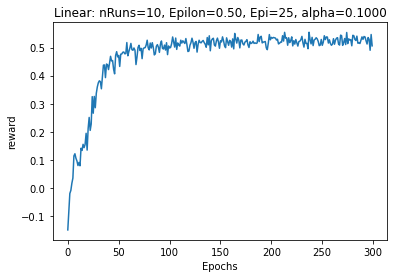

In [11]:
if __name__ == '__main__':
    state_texts = utils.load_data('game.tsv')
    dictionary = utils.bag_of_words(state_texts)
    state_dim = len(dictionary)

    # set up the game
    framework.load_game_data()

    epoch_rewards_test = []  # shape NUM_RUNS * NUM_EPOCHS

    for _ in range(NUM_RUNS):
        epoch_rewards_test.append(run())

    epoch_rewards_test = np.array(epoch_rewards_test)

    x = np.arange(NUM_EPOCHS)
    fig, axis = plt.subplots()
    axis.plot(x, np.mean(epoch_rewards_test,
                         axis=0))  # plot reward per epoch averaged per run
    axis.set_xlabel('Epochs')
    axis.set_ylabel('reward')
    axis.set_title(('Linear: nRuns=%d, Epilon=%.2f, Epi=%d, alpha=%.4f' %
                    (NUM_RUNS, TRAINING_EP, NUM_EPIS_TRAIN, ALPHA)))
    plt.show()